# Imports

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Part A

## Normalization of data

- We first read both files since the dataset was provided as train and test not as one csv file
- We then dropped the header row from both tables and concatenated them together to create the dataset
- We converted the data into a numpy array for faster operations
- We then seperated the labels into `y` and the features in `X` and set their data types
- Feature values were normalized to take value between `0 and 1`
- Afterwards we split the data into train, validation, and test

In [29]:
data=pd.read_csv("dataset/mnist_test.csv")
data2=pd.read_csv("dataset/mnist_train.csv")
data2=data2.drop(data2.index[0])
data=data.drop(data.index[0])
data=pd.concat([data,data2])

data_np = data.to_numpy()

# Separate labels (first column) and features (remaining columns)
y = data_np[:, 0].astype(int)
X = data_np[:, 1:].astype(float)

# Normalize pixel values to [0, 1]
X = X / 255.0

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


  - `reshape()` is a numpy function that changes the dimension of a numpy array without changing the data
  - since the images were in the form of a flattened vector, we can change them back into 28x28 images using the `reshape() `
  - -1 -> it tells the function to automatically calculate this dimesion according to the other dimensions we will specifiy later (this one returns the number of images)
  - 1 -> number of color channels (only 1 since the images are grayscale)
  - 28 -> height
  - 28 -> width

In [30]:

# Reshape for neural networks
X_train_nn = X_train.reshape(-1, 1, 28, 28)
X_val_nn = X_val.reshape(-1, 1, 28, 28)
X_test_nn = X_test.reshape(-1, 1, 28, 28)


In [31]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# For neural networks (keep image shape)
X_train_nn_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
X_val_nn_tensor = torch.tensor(X_val_nn, dtype=torch.float32)
X_test_nn_tensor = torch.tensor(X_test_nn, dtype=torch.float32)

# Create TensorDatasets
train_dataset_flat = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_flat = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_flat = TensorDataset(X_test_tensor, y_test_tensor)

train_dataset_nn = TensorDataset(X_train_nn_tensor, y_train_tensor)
val_dataset_nn = TensorDataset(X_val_nn_tensor, y_val_tensor)
test_dataset_nn = TensorDataset(X_test_nn_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64

train_loader_flat = DataLoader(train_dataset_flat, batch_size=batch_size, shuffle=True)
val_loader_flat = DataLoader(val_dataset_flat, batch_size=batch_size, shuffle=False)
test_loader_flat = DataLoader(test_dataset_flat, batch_size=batch_size, shuffle=False)

train_loader_nn = DataLoader(train_dataset_nn, batch_size=batch_size, shuffle=True)
val_loader_nn = DataLoader(val_dataset_nn, batch_size=batch_size, shuffle=False)
test_loader_nn = DataLoader(test_dataset_nn, batch_size=batch_size, shuffle=False)

## Binary logistic regression

In [32]:
# Filter only 0 and 1 from training set
train_mask = (y_train == 0) | (y_train == 1)
val_mask = (y_val == 0) | (y_val == 1)
test_mask = (y_test == 0) | (y_test == 1)

X_train_bin = X_train_tensor[train_mask]
y_train_bin = y_train_tensor[train_mask]

X_val_bin = X_val_tensor[val_mask]
y_val_bin = y_val_tensor[val_mask]

X_test_bin = X_test_tensor[test_mask]
y_test_bin = y_test_tensor[test_mask]

# Create dataloaders
batch_size = 64
train_loader_bin = DataLoader(TensorDataset(X_train_bin, y_train_bin), batch_size=batch_size, shuffle=True)
val_loader_bin = DataLoader(TensorDataset(X_val_bin, y_val_bin), batch_size=batch_size, shuffle=False)
test_loader_bin = DataLoader(TensorDataset(X_test_bin, y_test_bin), batch_size=batch_size, shuffle=False)


In [33]:
input_dim = 784  # flattened MNIST size

# Weights & bias
W = torch.zeros(input_dim, 1, dtype=torch.float32, requires_grad=True)
b = torch.zeros(1, dtype=torch.float32, requires_grad=True)

learning_rate = 0.01


In [34]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def binary_cross_entropy(pred, target):
    # Adding small epsilon for numerical stability
    eps = 1e-8
    return -(target * torch.log(pred + eps) + (1 - target) * torch.log(1 - pred + eps)).mean()


In [35]:
def evaluate(loader):
    correct = 0
    total = 0
    loss_sum = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            y_batch = y_batch.unsqueeze(1).float()
            logits = X_batch @ W + b
            y_pred = sigmoid(logits)
            loss = binary_cross_entropy(y_pred, y_batch)
            predicted = (y_pred >= 0.5).int()
            correct += (predicted.squeeze() == y_batch.squeeze()).sum().item()
            total += y_batch.size(0)
            loss_sum += loss.item()
    return loss_sum / len(loader), correct / total

In [36]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = 20

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader_bin:
        y_batch = y_batch.unsqueeze(1).float()
        logits = X_batch @ W + b
        y_pred = sigmoid(logits)

        loss = binary_cross_entropy(y_pred, y_batch)
        loss.backward()

        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        W.grad.zero_()
        b.grad.zero_()

        total_loss += loss.item()
        predicted = (y_pred >= 0.5).int()
        correct += (predicted.squeeze() == y_batch.squeeze()).sum().item()
        total += y_batch.size(0)

    train_loss = total_loss / len(train_loader_bin)
    train_acc = correct / total
    val_loss, val_acc = evaluate(val_loader_bin)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)


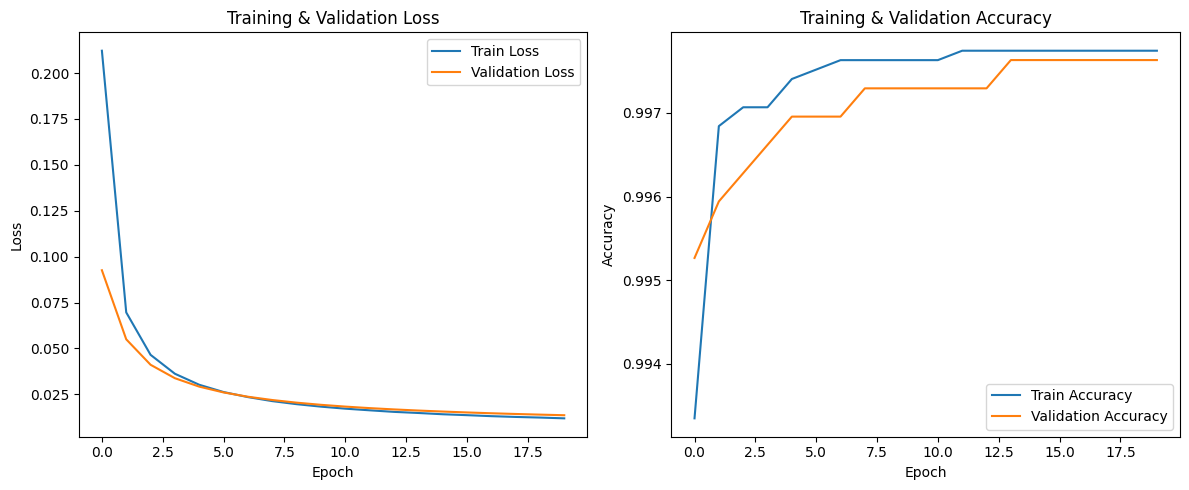

In [37]:
plt.figure(figsize=(12,5))

# Loss curves
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy curves
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


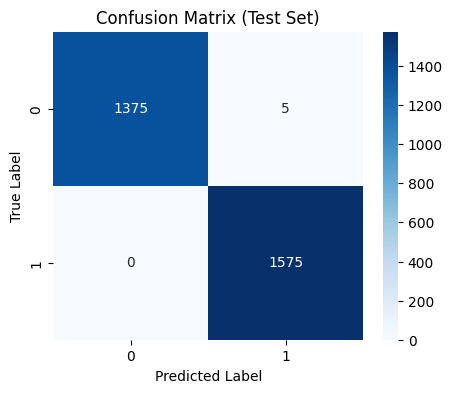

Final Test Accuracy: 0.9983


In [38]:
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader_bin:
        logits = X_batch @ W + b
        y_pred = sigmoid(logits)
        preds = (y_pred >= 0.5).int().squeeze().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()

test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Final Test Accuracy: {test_acc:.4f}")



## Softmax Regression Implementation

Epoch 10/100, Loss: 0.4009, Val Acc: 0.9075
Epoch 20/100, Loss: 0.3849, Val Acc: 0.9120
Epoch 30/100, Loss: 0.3795, Val Acc: 0.9137
Epoch 40/100, Loss: 0.3764, Val Acc: 0.9126
Epoch 50/100, Loss: 0.3782, Val Acc: 0.9089


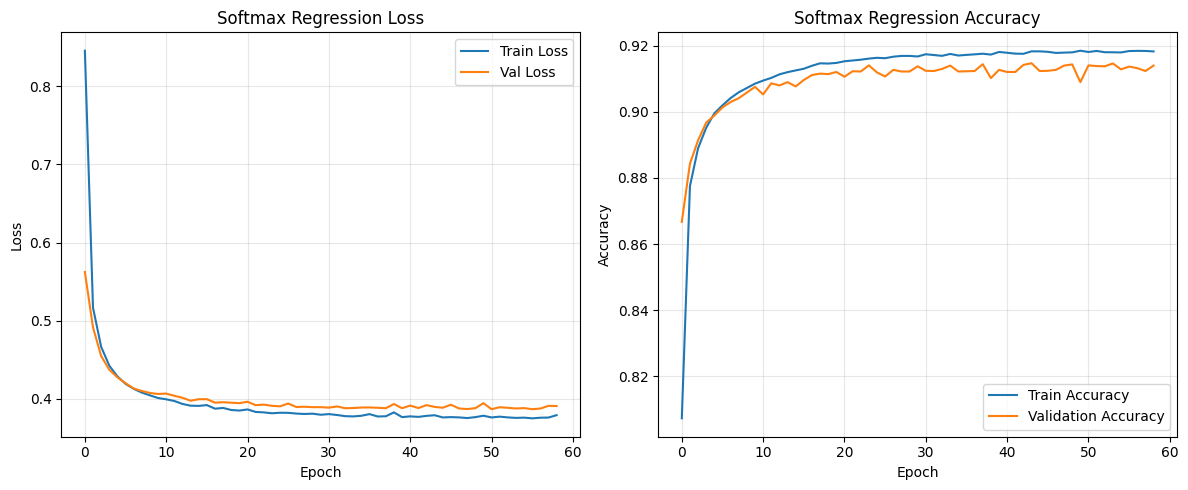

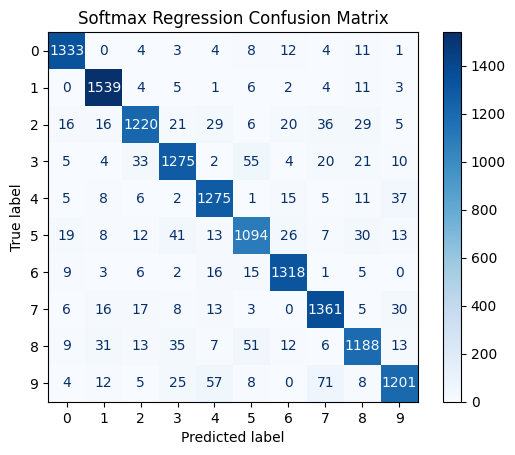


Per-Class Accuracy:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1380
           1       0.94      0.98      0.96      1575
           2       0.92      0.87      0.90      1398
           3       0.90      0.89      0.90      1429
           4       0.90      0.93      0.92      1365
           5       0.88      0.87      0.87      1263
           6       0.94      0.96      0.95      1375
           7       0.90      0.93      0.92      1459
           8       0.90      0.87      0.89      1365
           9       0.91      0.86      0.89      1391

    accuracy                           0.91     14000
   macro avg       0.91      0.91      0.91     14000
weighted avg       0.91      0.91      0.91     14000

Final Test Accuracy: 91.46%


In [48]:
def train_softmax_minibatch(X_train, y_train, X_val, y_val, epochs=100, lr=0.1, batch_size=256, lambda_reg=0.001):
    n_samples = X_train.shape[0]
    num_features = X_train.shape[1]
    num_classes = len(torch.unique(y_train))

    limit = np.sqrt(6.0 / (num_features + num_classes))
    W = torch.FloatTensor(num_features, num_classes).uniform_(-limit, limit)
    b = torch.zeros(num_classes)
    W.requires_grad = True
    b.requires_grad = True

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    best_W, best_b = None, None
    patience_counter = 0

    for epoch in range(epochs):
        indices = torch.randperm(n_samples)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        epoch_loss = 0.0
        epoch_correct = 0
        n_batches = 0

        for i in range(0, n_samples, batch_size):
            batch_X = X_shuffled[i:i+batch_size]
            batch_y = y_shuffled[i:i+batch_size]

            if len(batch_y) == 0:
                continue

            logits = batch_X @ W + b
            loss = torch.nn.functional.cross_entropy(logits, batch_y)
            if lambda_reg > 0:
                loss = loss + lambda_reg * (W ** 2).sum()

            loss.backward()
            torch.nn.utils.clip_grad_norm_([W, b], max_norm=5.0)

            with torch.no_grad():
                W -= lr * W.grad
                b -= lr * b.grad
                W.grad.zero_()
                b.grad.zero_()

            with torch.no_grad():
                preds = logits.argmax(dim=1)
                epoch_correct += (preds == batch_y).sum().item()
                epoch_loss += loss.item()
                n_batches += 1

        train_loss = epoch_loss / n_batches
        train_acc = epoch_correct / n_samples

        with torch.no_grad():
            val_logits = X_val @ W + b
            val_loss = torch.nn.functional.cross_entropy(val_logits, y_val)
            if lambda_reg > 0:
                val_loss = val_loss + lambda_reg * (W ** 2).sum()
            val_preds = val_logits.argmax(dim=1)
            val_acc = (val_preds == y_val).float().mean().item()

        train_losses.append(train_loss)
        val_losses.append(val_loss.item())
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_W = W.clone().detach()
            best_b = b.clone().detach()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

        if patience_counter >= 15:
            break

    W.data = best_W
    b.data = best_b
    return W, b, train_losses, val_losses, train_accs, val_accs

X_train_mc = torch.tensor(X_train, dtype=torch.float32)
y_train_mc = torch.tensor(y_train, dtype=torch.long)
X_val_mc = torch.tensor(X_val, dtype=torch.float32)
y_val_mc = torch.tensor(y_val, dtype=torch.long)
X_test_mc = torch.tensor(X_test, dtype=torch.float32)
y_test_mc = torch.tensor(y_test, dtype=torch.long)

W, b, train_losses_mc, val_losses_mc, train_accs_mc, val_accs_mc = train_softmax_minibatch(
    X_train_mc, y_train_mc, X_val_mc, y_val_mc,
    epochs=100, lr=0.1, batch_size=256, lambda_reg=0.001
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_mc, label="Train Loss")
plt.plot(val_losses_mc, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Softmax Regression Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs_mc, label="Train Accuracy")
plt.plot(val_accs_mc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Softmax Regression Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

with torch.no_grad():
    test_logits = X_test_mc @ W + b
    test_pred = test_logits.argmax(dim=1)
    test_acc = (test_pred == y_test_mc).float().mean().item()


cm = confusion_matrix(y_test_mc, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Softmax Regression Confusion Matrix")
plt.show()

print("\nPer-Class Accuracy:")
print(classification_report(y_test_mc, test_pred))
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

# Part B

### Custom Neural Network Architecture

The **FullyConnectedNN** class implements the ANN. My implementation allows for different depths of the linear NN layers. Some important functions used:
- **nn.Linear**: instantiates a linear transformation layer, that applies the formula `y = xW^T + b`
- **nn.init.kaiming_normal_**: initialises the weights for the layers that use **ReLU** activation function and its variants to account for the fact that on average 50% of the weight would be 0, as **`RelU(x) = max(0, x)`**
- **nn.init.xavier_normal_**: initialises the weights for the layers that use activation functions that have zero mean and unit variance, such as the sigmoid function that is used in softmax regression


In [ ]:
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 64], num_classes=10):
        super(FullyConnectedNN, self).__init__()

        layers = []
        in_features = input_size

        for h in hidden_sizes:
            layers.append(nn.Linear(in_features, h))
            in_features = h

        layers.append(nn.Linear(in_features, num_classes))

        self.layers = nn.ModuleList(layers)

        for layer in self.layers[:-1]:
            nn.init.kaiming_normal_(layer.weight)
        nn.init.xavier_normal_(self.layers[-1].weight)

    def forward(self, x):
        if x.ndim == 4:
            x = x.view(x.size(0), -1)

        for layer in self.layers[:-1]:
            x = F.relu(layer(x))

        return self.layers[-1](x)


### Training Infrastructure

Auto-detection of a GPU and using it if exists. Otherwise, fall back onto CPU.

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

Training on: cuda


The **accuracy** function calculates the accuracy per batch by:
- Taking the **outputs**, which are the raw logits, and the **labels**
- Getting the prediction by getting the maximum value using **argmax**
- Calculating the mean of how many predictions actually matched the labels

In [24]:
def accuracy(outputs, labels):
    preds = outputs.argmax(dim=1)
    return (preds == labels).float().mean().item()

In [25]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.01):
    model = model.to(device) # Move model to device

    criterion = nn.CrossEntropyLoss() # combines softmax and negative log likelihood

    # Stochastic Gradient Descent optimizer
    # model.parameters() gives all learnable parameters of the model to be optimized
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train() # set the model to training mode

        running_loss = 0.0
        running_acc = 0.0

        for X, y in train_loader: # train the model in batches
            X, y = X.to(device), y.to(device)

            outputs = model(X) # calls the forward function and returns raw logits
            loss = criterion(outputs, y) # computes how far the outputs are from the true labels

            optimizer.zero_grad() # reset gradients before backpropagation to prevent unwanted accumulation
            loss.backward() # compute gradients via backpropagation
            optimizer.step() # update model parameters using w = w - lr * gradient

            running_loss += loss.item()
            running_acc += accuracy(outputs, y)

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(running_acc / len(train_loader))

        model.eval() # set the model to validation mode
        val_loss, val_acc = 0.0, 0.0

        with torch.no_grad(): # disable gradient calculation during validation
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)

                outputs = model(X)
                loss = criterion(outputs, y)

                val_loss += loss.item()
                val_acc += accuracy(outputs, y)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_acc / len(val_loader))

        # Log progress
        print(f"Epoch [{epoch+1}/{epochs}] "
            f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]*100:.2f}% "
            f"| Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]*100:.2f}%")

    return train_losses, val_losses, train_accs, val_accs


- Run the fully connected NN model training

In [26]:
fc_nn_model = FullyConnectedNN()
train_losses, val_losses, train_accs, val_accs = train_model(
    fc_nn_model,
    train_loader_nn,
    val_loader_nn,
    epochs=10,
    lr=0.01
)

NameError: name 'train_loader_nn' is not defined

- Performance Visualization

Plotting training history for single run...


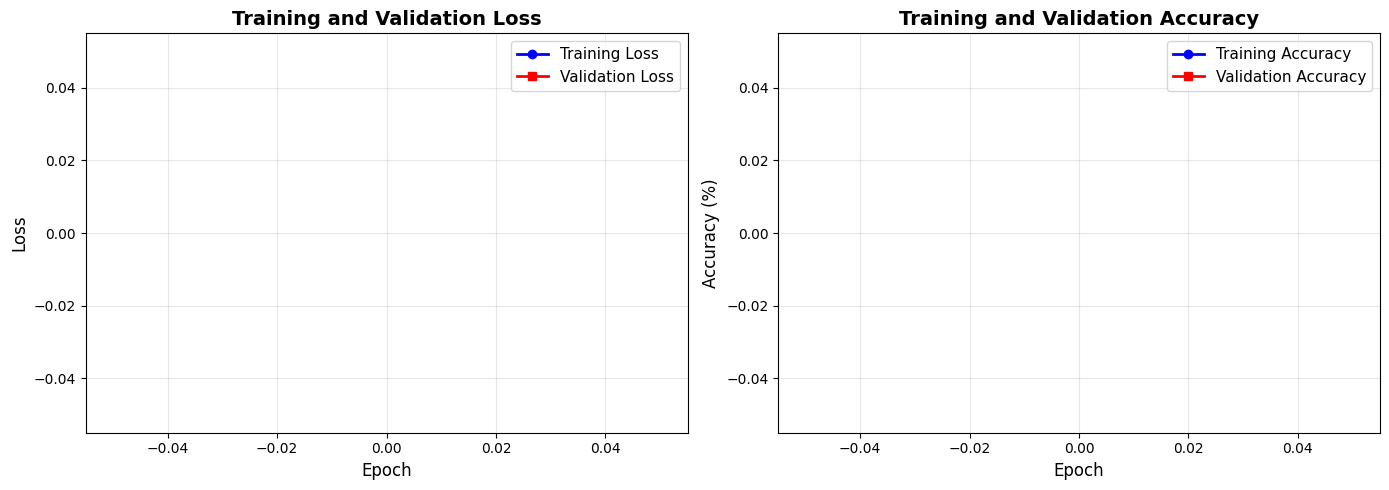


Performing convergence analysis...


IndexError: list index out of range

In [27]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """
    Plot training and validation metrics over epochs.

    Args:
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
        train_accs: List of training accuracies per epoch
        val_accs: List of validation accuracies per epoch
    """
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Loss over epochs
    ax1.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
    ax1.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Accuracy over epochs
    ax2.plot(epochs, [acc * 100 for acc in train_accs], 'b-o',
             label='Training Accuracy', linewidth=2, markersize=6)
    ax2.plot(epochs, [acc * 100 for acc in val_accs], 'r-s',
             label='Validation Accuracy', linewidth=2, markersize=6)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def train_model_multiple_runs(model_class, train_loader, val_loader,
                               epochs=10, lr=0.01, num_runs=5):
    """
    Train the model multiple times to compute statistics for error bars.

    Args:
        model_class: The model class to instantiate
        train_loader: Training data loader
        val_loader: Validation data loader
        epochs: Number of training epochs
        lr: Learning rate
        num_runs: Number of independent training runs

    Returns:
        Dictionary containing mean and std of losses and accuracies
    """
    all_train_losses = []
    all_val_losses = []
    all_train_accs = []
    all_val_accs = []

    for run in range(num_runs):
        print(f"\n{'='*50}")
        print(f"Training Run {run + 1}/{num_runs}")
        print(f"{'='*50}")

        # Create a new model instance for each run
        model = model_class()

        # Train the model
        train_losses, val_losses, train_accs, val_accs = train_model(
            model, train_loader, val_loader, epochs=epochs, lr=lr
        )

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accs.append(train_accs)
        all_val_accs.append(val_accs)

    # Convert to numpy arrays for easier computation
    all_train_losses = np.array(all_train_losses)
    all_val_losses = np.array(all_val_losses)
    all_train_accs = np.array(all_train_accs)
    all_val_accs = np.array(all_val_accs)

    return {
        'train_loss_mean': all_train_losses.mean(axis=0),
        'train_loss_std': all_train_losses.std(axis=0),
        'val_loss_mean': all_val_losses.mean(axis=0),
        'val_loss_std': all_val_losses.std(axis=0),
        'train_acc_mean': all_train_accs.mean(axis=0),
        'train_acc_std': all_train_accs.std(axis=0),
        'val_acc_mean': all_val_accs.mean(axis=0),
        'val_acc_std': all_val_accs.std(axis=0),
    }


def plot_learning_curves_with_error_bars(stats):
    """
    Plot learning curves with error bars (mean ± std).

    Args:
        stats: Dictionary containing mean and std of metrics from multiple runs
    """
    epochs = range(1, len(stats['train_loss_mean']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Loss with error bars
    ax1.errorbar(epochs, stats['train_loss_mean'], yerr=stats['train_loss_std'],
                 fmt='b-o', label='Training Loss', capsize=5, linewidth=2,
                 markersize=6, alpha=0.8)
    ax1.errorbar(epochs, stats['val_loss_mean'], yerr=stats['val_loss_std'],
                 fmt='r-s', label='Validation Loss', capsize=5, linewidth=2,
                 markersize=6, alpha=0.8)
    ax1.fill_between(epochs,
                      stats['train_loss_mean'] - stats['train_loss_std'],
                      stats['train_loss_mean'] + stats['train_loss_std'],
                      alpha=0.2, color='blue')
    ax1.fill_between(epochs,
                      stats['val_loss_mean'] - stats['val_loss_std'],
                      stats['val_loss_mean'] + stats['val_loss_std'],
                      alpha=0.2, color='red')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Learning Curves: Loss (Mean ± Std)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Accuracy with error bars
    train_acc_mean_pct = stats['train_acc_mean'] * 100
    train_acc_std_pct = stats['train_acc_std'] * 100
    val_acc_mean_pct = stats['val_acc_mean'] * 100
    val_acc_std_pct = stats['val_acc_std'] * 100

    ax2.errorbar(epochs, train_acc_mean_pct, yerr=train_acc_std_pct,
                 fmt='b-o', label='Training Accuracy', capsize=5, linewidth=2,
                 markersize=6, alpha=0.8)
    ax2.errorbar(epochs, val_acc_mean_pct, yerr=val_acc_std_pct,
                 fmt='r-s', label='Validation Accuracy', capsize=5, linewidth=2,
                 markersize=6, alpha=0.8)
    ax2.fill_between(epochs,
                      train_acc_mean_pct - train_acc_std_pct,
                      train_acc_mean_pct + train_acc_std_pct,
                      alpha=0.2, color='blue')
    ax2.fill_between(epochs,
                      val_acc_mean_pct - val_acc_std_pct,
                      val_acc_mean_pct + val_acc_std_pct,
                      alpha=0.2, color='red')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Learning Curves: Accuracy (Mean ± Std)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def analyze_convergence(train_losses, val_losses, train_accs, val_accs,
                        window_size=3, threshold=0.001):
    """
    Analyze model convergence based on loss and accuracy trends.

    Args:
        train_losses: Training losses per epoch
        val_losses: Validation losses per epoch
        train_accs: Training accuracies per epoch
        val_accs: Validation accuracies per epoch
        window_size: Window size for computing moving average
        threshold: Threshold for detecting convergence
    """
    epochs = len(train_losses)

    # Compute moving average of loss changes
    train_loss_changes = np.abs(np.diff(train_losses))
    val_loss_changes = np.abs(np.diff(val_losses))

    # Detect convergence point (when changes are consistently small)
    converged_epoch = None
    for i in range(window_size - 1, len(train_loss_changes)):
        window = train_loss_changes[i - window_size + 1:i + 1]
        if np.mean(window) < threshold:
            converged_epoch = i + 2  # +2 because diff reduces length by 1, and we want 1-indexed
            break

    # Check for overfitting (validation loss increasing while training loss decreasing)
    overfitting_start = None
    for i in range(1, len(val_losses)):
        if val_losses[i] > val_losses[i-1] and train_losses[i] < train_losses[i-1]:
            # Check if this trend continues for a few epochs
            if i < len(val_losses) - 2:
                if val_losses[i+1] > val_losses[i]:
                    overfitting_start = i + 1  # 1-indexed
                    break

    # Compute generalization gap
    final_gap = abs(train_accs[-1] - val_accs[-1]) * 100

    # Create convergence analysis plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Loss change over epochs
    ax1.plot(range(2, epochs + 1), train_loss_changes, 'b-o',
             label='Training Loss Change', linewidth=2, markersize=4)
    ax1.plot(range(2, epochs + 1), val_loss_changes, 'r-s',
             label='Validation Loss Change', linewidth=2, markersize=4)
    ax1.axhline(y=threshold, color='g', linestyle='--', label=f'Convergence Threshold ({threshold})')
    if converged_epoch:
        ax1.axvline(x=converged_epoch, color='purple', linestyle='--',
                   label=f'Convergence at Epoch {converged_epoch}')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Absolute Loss Change', fontsize=12)
    ax1.set_title('Loss Change Over Epochs', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Loss curves with overfitting indicator
    ax2.plot(range(1, epochs + 1), train_losses, 'b-o',
             label='Training Loss', linewidth=2, markersize=6)
    ax2.plot(range(1, epochs + 1), val_losses, 'r-s',
             label='Validation Loss', linewidth=2, markersize=6)
    if overfitting_start:
        ax2.axvline(x=overfitting_start, color='orange', linestyle='--',
                   label=f'Potential Overfitting at Epoch {overfitting_start}')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Loss Curves with Overfitting Detection', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Plot 3: Generalization gap over epochs
    gen_gap = [(train_accs[i] - val_accs[i]) * 100 for i in range(epochs)]
    ax3.plot(range(1, epochs + 1), gen_gap, 'g-o', linewidth=2, markersize=6)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax3.fill_between(range(1, epochs + 1), 0, gen_gap, alpha=0.3, color='green')
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Generalization Gap (%)', fontsize=12)
    ax3.set_title('Generalization Gap (Train Acc - Val Acc)', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Summary metrics table
    ax4.axis('off')
    summary_data = [
        ['Metric', 'Value'],
        ['Final Train Loss', f'{train_losses[-1]:.4f}'],
        ['Final Val Loss', f'{val_losses[-1]:.4f}'],
        ['Final Train Accuracy', f'{train_accs[-1]*100:.2f}%'],
        ['Final Val Accuracy', f'{val_accs[-1]*100:.2f}%'],
        ['Generalization Gap', f'{final_gap:.2f}%'],
        ['Best Val Accuracy', f'{max(val_accs)*100:.2f}% (Epoch {np.argmax(val_accs)+1})'],
        ['Converged at Epoch', str(converged_epoch) if converged_epoch else 'Not detected'],
        ['Overfitting Start', str(overfitting_start) if overfitting_start else 'None detected'],
    ]

    table = ax4.table(cellText=summary_data, cellLoc='left', loc='center',
                     colWidths=[0.5, 0.5])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)

    # Style the header row
    for i in range(2):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Alternate row colors
    for i in range(1, len(summary_data)):
        for j in range(2):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')

    ax4.set_title('Convergence Analysis Summary', fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

    # Print textual analysis
    print("\n" + "="*60)
    print("CONVERGENCE ANALYSIS REPORT")
    print("="*60)
    print(f"\n📊 Final Performance:")
    print(f"   • Training Loss: {train_losses[-1]:.4f}")
    print(f"   • Validation Loss: {val_losses[-1]:.4f}")
    print(f"   • Training Accuracy: {train_accs[-1]*100:.2f}%")
    print(f"   • Validation Accuracy: {val_accs[-1]*100:.2f}%")

    print(f"\n🎯 Best Performance:")
    print(f"   • Best Validation Accuracy: {max(val_accs)*100:.2f}% at Epoch {np.argmax(val_accs)+1}")
    print(f"   • Best Validation Loss: {min(val_losses):.4f} at Epoch {np.argmin(val_losses)+1}")

    print(f"\n📈 Convergence Status:")
    if converged_epoch:
        print(f"   • Model converged at epoch {converged_epoch}")
        print(f"   • Loss changes became stable (< {threshold})")
    else:
        print(f"   • Model did not converge within {epochs} epochs")
        print(f"   • Consider training for more epochs")

    print(f"\n⚠️  Overfitting Analysis:")
    if overfitting_start:
        print(f"   • Potential overfitting detected starting at epoch {overfitting_start}")
        print(f"   • Validation loss increased while training loss decreased")
        print(f"   • Consider early stopping at epoch {overfitting_start - 1}")
    else:
        print(f"   • No clear overfitting detected")

    print(f"\n🔍 Generalization:")
    print(f"   • Final generalization gap: {final_gap:.2f}%")
    if final_gap < 5:
        print(f"   • Excellent generalization (gap < 5%)")
    elif final_gap < 10:
        print(f"   • Good generalization (gap < 10%)")
    else:
        print(f"   • Poor generalization (gap >= 10%) - model may be overfitting")

    print("\n" + "="*60)


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

# 1. Simple visualization of single training run
print("Plotting training history for single run...")
plot_training_history(train_losses, val_losses, train_accs, val_accs)

# 2. Multiple runs with error bars (uncomment to use)
# print("\nTraining model multiple times for statistical analysis...")
# stats = train_model_multiple_runs(
#     FullyConnectedNN,
#     train_loader_nn,
#     val_loader_nn,
#     epochs=10,
#     lr=0.01,
#     num_runs=5
# )
# plot_learning_curves_with_error_bars(stats)

# 3. Convergence analysis
print("\nPerforming convergence analysis...")
analyze_convergence(train_losses, val_losses, train_accs, val_accs)

# Part C

- Hyperparameter Analysis

- Model Comparison

# Part D

### Convolutional Neural Networks

In [ ]:
class DynamicCNN(nn.Module):
    def __init__(self, conv_channels=[32, 64], fc_sizes=[128], num_classes=10):
        super(DynamicCNN, self).__init__()

        layers = []
        in_channels = 1

        for out_channels in conv_channels:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2))
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)

        pool_count = conv_channels.__len__()
        spatial_size = 28 // (2 ** pool_count)

        fc_layers = []
        in_features = conv_channels[-1] * spatial_size * spatial_size

        for h in fc_sizes:
            fc_layers.append(nn.Linear(in_features, h))
            fc_layers.append(nn.ReLU())
            in_features = h

        fc_layers.append(nn.Linear(in_features, num_classes))
        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

- Run the convolutional NN model training

In [ ]:
cnn_model = DynamicCNN()
train_losses, val_losses, train_accs, val_accs = train_model(
    cnn_model,
    train_loader_nn,
    val_loader_nn,
    epochs=10,
    lr=0.01
)